In [1]:
import os
import re
import math
import glob
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.rulesets.hitobjects as hitobjects
import osu.dataset as dataset

import osu.preview.preview as preview

pygame 2.6.1 (SDL 2.28.4, Python 3.13.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


E:\Projects\osu\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
APP_DATA = os.getenv("APPDATA")
OSU_PATH = f'{APP_DATA}/../Local/osu!'

print(OSU_PATH)

test_map = 'assets/1hope_map.osu'
test_replay = 'assets/1hope_replay.osr'
test_song = 'assets/1hope_song.mp3'

C:\Users\niooi\AppData\Roaming/../Local/osu!


In [3]:
test_map = bm.load(test_map)
test_replay = rp.load(test_replay)

files = dataset.all_files(OSU_PATH)
files

,replay,beatmap
0,C:\Users\niooi\AppData\Roaming/../Local/osu!\R...,C:\Users\niooi\AppData\Roaming/../Local/osu!\S...
1,C:\Users\niooi\AppData\Roaming/../Local/osu!\R...,C:\Users\niooi\AppData\Roaming/../Local/osu!\S...
2,C:\Users\niooi\AppData\Roaming/../Local/osu!\R...,C:\Users\niooi\AppData\Roaming/../Local/osu!\S...
3,C:\Users\niooi\AppData\Roaming/../Local/osu!\R...,C:\Users\niooi\AppData\Roaming/../Local/osu!\S...
4,C:\Users\niooi\AppData\Roaming/../Local/osu!\R...,C:\Users\niooi\AppData\Roaming/../Local/osu!\S...
...,...,...
287,C:\Users\niooi\AppData\Roaming/../Local/osu!\R...,C:\Users\niooi\AppData\Roaming/../Local/osu!\S...
288,C:\Users\niooi\AppData\Roaming/../Local/osu!\R...,C:\Users\niooi\AppData\Roaming/../Local/osu!\S...
289,C:\Users\niooi\AppData\Roaming/../Local/osu!\R...,C:\Users\niooi\AppData\Roaming/../Local/osu!\S...
290,C:\Users\niooi\AppData\Roaming/../Local/osu!\R...,C:\Users\niooi\AppData\Roaming/../Local/osu!\S...


In [4]:
obj_dataset = dataset.load(files, verbose=False)

In [5]:
obj_dataset

,replay,beatmap
0,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
1,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
3,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
...,...,...
283,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
284,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
285,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
286,<osu.rulesets.replay.Replay object at 0x000002...,<osu.rulesets.beatmap.Beatmap object at 0x0000...


In [6]:
input = dataset.input_data(obj_dataset, verbose=True)
output = dataset.target_data(obj_dataset, verbose=True)

288it [01:40,  2.86it/s]
E:\Projects\osu\osu\dataset.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  tensor_list = [torch.tensor(seq, dtype=torch.float) for seq in data]
288it [00:02, 111.54it/s]


In [7]:
output

x         y
chunk frame                    
0     0      0.328315  0.235828
      1      0.328315  0.235828
      2      0.342116  0.251298
      3      0.345771  0.257958
      4      0.345771  0.257958
...               ...       ...
789   2043   0.000000  0.000000
      2044   0.000000  0.000000
      2045   0.000000  0.000000
      2046   0.000000  0.000000
      2047   0.000000  0.000000

[1617920 rows x 2 columns]

In [8]:
import torch

xs = np.reshape(input.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))

# try:
#     target_data = pd.read_pickle('.data/target_data.dat')
# except:
#     target_data = dataset.target_data(dataset, verbose=True)
#     target_data.to_pickle('.data/target_data.dat')

ys = np.reshape(output.values, (-1, dataset.BATCH_LENGTH, len(dataset.OUTPUT_FEATURES)))

ys.shape

(790, 2048, 2)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class OsuModel(nn.Module):
    def __init__(self, input_size, output_size, noise_std=0.2):
        super(OsuModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.dense1 = nn.Linear(64, 64)
        self.noise_std = noise_std
        self.dense2 = nn.Linear(64, 16)
        self.position = nn.Linear(16, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        pos = self.dense1(lstm_out)
        
        # gaussian noise (only applied during training)
        if self.training:
            noise = torch.randn_like(pos) * self.noise_std
            pos = pos + noise
        
        pos = self.dense2(pos)
        pos = self.position(pos)
        
        return pos

input_size = xs.shape[2]  # feature dimension
output_size = ys.shape[2]  # output dimension

model = OsuModel(input_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()  # MAE equivalent

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

OsuModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=16, bias=True)
  (position): Linear(in_features=16, out_features=2, bias=True)
)
Total parameters: 23410


In [10]:
from sklearn.model_selection import train_test_split
from random import randint 
from torch.utils.data import DataLoader, TensorDataset

EPOCHS = 500
BATCH_SIZE = 32

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.3, random_state=randint(0, 100))

train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [11]:
epoch_losses = []

In [12]:
import tqdm

for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_x, batch_y in tqdm.tqdm(train_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        # print(batch_x.shape)
        # print(batch_y.shape)
        optimizer.zero_grad()
        outputs = model(batch_x)
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss = epoch_loss/len(train_loader)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}')
    epoch_losses.append(epoch_loss)
    

100%|██████████| 18/18 [00:00<00:00, 19.97it/s]


Epoch 1/500, Loss: 0.1650


100%|██████████| 18/18 [00:00<00:00, 68.88it/s]


Epoch 2/500, Loss: 0.1539


100%|██████████| 18/18 [00:00<00:00, 67.70it/s]


Epoch 3/500, Loss: 0.1406


100%|██████████| 18/18 [00:00<00:00, 68.35it/s]


Epoch 4/500, Loss: 0.1257


100%|██████████| 18/18 [00:00<00:00, 67.96it/s]


Epoch 5/500, Loss: 0.1168


100%|██████████| 18/18 [00:00<00:00, 67.69it/s]


Epoch 6/500, Loss: 0.1145


100%|██████████| 18/18 [00:00<00:00, 65.25it/s]


Epoch 7/500, Loss: 0.1106


100%|██████████| 18/18 [00:00<00:00, 69.27it/s]


Epoch 8/500, Loss: 0.1078


100%|██████████| 18/18 [00:00<00:00, 66.61it/s]


Epoch 9/500, Loss: 0.1093


100%|██████████| 18/18 [00:00<00:00, 67.55it/s]


Epoch 10/500, Loss: 0.1069


100%|██████████| 18/18 [00:00<00:00, 69.51it/s]


Epoch 11/500, Loss: 0.1070


100%|██████████| 18/18 [00:00<00:00, 68.13it/s]


Epoch 12/500, Loss: 0.1054


100%|██████████| 18/18 [00:00<00:00, 69.07it/s]


Epoch 13/500, Loss: 0.1049


100%|██████████| 18/18 [00:00<00:00, 68.51it/s]


Epoch 14/500, Loss: 0.1064


100%|██████████| 18/18 [00:00<00:00, 66.47it/s]


Epoch 15/500, Loss: 0.1047


100%|██████████| 18/18 [00:00<00:00, 69.19it/s]


Epoch 16/500, Loss: 0.1047


100%|██████████| 18/18 [00:00<00:00, 67.14it/s]


Epoch 17/500, Loss: 0.1056


100%|██████████| 18/18 [00:00<00:00, 69.01it/s]


Epoch 18/500, Loss: 0.1047


100%|██████████| 18/18 [00:00<00:00, 66.48it/s]


Epoch 19/500, Loss: 0.1056


100%|██████████| 18/18 [00:00<00:00, 67.27it/s]


Epoch 20/500, Loss: 0.1043


100%|██████████| 18/18 [00:00<00:00, 66.36it/s]


Epoch 21/500, Loss: 0.1042


100%|██████████| 18/18 [00:00<00:00, 68.59it/s]


Epoch 22/500, Loss: 0.1041


100%|██████████| 18/18 [00:00<00:00, 65.72it/s]


Epoch 23/500, Loss: 0.1053


100%|██████████| 18/18 [00:00<00:00, 68.50it/s]


Epoch 24/500, Loss: 0.1037


100%|██████████| 18/18 [00:00<00:00, 66.28it/s]


Epoch 25/500, Loss: 0.1043


100%|██████████| 18/18 [00:00<00:00, 65.83it/s]


Epoch 26/500, Loss: 0.1029


100%|██████████| 18/18 [00:00<00:00, 70.68it/s]


Epoch 27/500, Loss: 0.1021


100%|██████████| 18/18 [00:00<00:00, 65.80it/s]


Epoch 28/500, Loss: 0.1028


100%|██████████| 18/18 [00:00<00:00, 69.22it/s]


Epoch 29/500, Loss: 0.1039


100%|██████████| 18/18 [00:00<00:00, 66.31it/s]


Epoch 30/500, Loss: 0.1044


100%|██████████| 18/18 [00:00<00:00, 66.68it/s]


Epoch 31/500, Loss: 0.1045


100%|██████████| 18/18 [00:00<00:00, 71.15it/s]


Epoch 32/500, Loss: 0.1026


100%|██████████| 18/18 [00:00<00:00, 67.15it/s]


Epoch 33/500, Loss: 0.1016


100%|██████████| 18/18 [00:00<00:00, 68.39it/s]


Epoch 34/500, Loss: 0.1041


100%|██████████| 18/18 [00:00<00:00, 66.74it/s]


Epoch 35/500, Loss: 0.1039


100%|██████████| 18/18 [00:00<00:00, 68.99it/s]


Epoch 36/500, Loss: 0.1022


100%|██████████| 18/18 [00:00<00:00, 67.70it/s]


Epoch 37/500, Loss: 0.1027


100%|██████████| 18/18 [00:00<00:00, 66.32it/s]


Epoch 38/500, Loss: 0.1022


100%|██████████| 18/18 [00:00<00:00, 69.51it/s]


Epoch 39/500, Loss: 0.1044


100%|██████████| 18/18 [00:00<00:00, 67.52it/s]


Epoch 40/500, Loss: 0.1033


100%|██████████| 18/18 [00:00<00:00, 67.73it/s]


Epoch 41/500, Loss: 0.1022


100%|██████████| 18/18 [00:00<00:00, 66.85it/s]


Epoch 42/500, Loss: 0.1042


100%|██████████| 18/18 [00:00<00:00, 67.80it/s]


Epoch 43/500, Loss: 0.1024


100%|██████████| 18/18 [00:00<00:00, 66.37it/s]


Epoch 44/500, Loss: 0.1021


100%|██████████| 18/18 [00:00<00:00, 68.93it/s]


Epoch 45/500, Loss: 0.1027


100%|██████████| 18/18 [00:00<00:00, 67.22it/s]


Epoch 46/500, Loss: 0.1024


100%|██████████| 18/18 [00:00<00:00, 67.82it/s]


Epoch 47/500, Loss: 0.1018


100%|██████████| 18/18 [00:00<00:00, 66.89it/s]


Epoch 48/500, Loss: 0.1043


100%|██████████| 18/18 [00:00<00:00, 66.58it/s]


Epoch 49/500, Loss: 0.1019


100%|██████████| 18/18 [00:00<00:00, 65.52it/s]


Epoch 50/500, Loss: 0.1024


100%|██████████| 18/18 [00:00<00:00, 67.63it/s]


Epoch 51/500, Loss: 0.1021


100%|██████████| 18/18 [00:00<00:00, 66.54it/s]


Epoch 52/500, Loss: 0.1018


100%|██████████| 18/18 [00:00<00:00, 67.42it/s]


Epoch 53/500, Loss: 0.1036


100%|██████████| 18/18 [00:00<00:00, 66.92it/s]


Epoch 54/500, Loss: 0.1046


100%|██████████| 18/18 [00:00<00:00, 67.33it/s]


Epoch 55/500, Loss: 0.1031


100%|██████████| 18/18 [00:00<00:00, 66.92it/s]


Epoch 56/500, Loss: 0.1020


100%|██████████| 18/18 [00:00<00:00, 64.68it/s]


Epoch 57/500, Loss: 0.1011


100%|██████████| 18/18 [00:00<00:00, 67.72it/s]


Epoch 58/500, Loss: 0.1047


100%|██████████| 18/18 [00:00<00:00, 66.77it/s]


Epoch 59/500, Loss: 0.1022


100%|██████████| 18/18 [00:00<00:00, 68.02it/s]


Epoch 60/500, Loss: 0.1036


100%|██████████| 18/18 [00:00<00:00, 67.72it/s]


Epoch 61/500, Loss: 0.1014


100%|██████████| 18/18 [00:00<00:00, 66.43it/s]


Epoch 62/500, Loss: 0.1034


100%|██████████| 18/18 [00:00<00:00, 67.81it/s]


Epoch 63/500, Loss: 0.1013


100%|██████████| 18/18 [00:00<00:00, 68.32it/s]


Epoch 64/500, Loss: 0.1028


100%|██████████| 18/18 [00:00<00:00, 67.25it/s]


Epoch 65/500, Loss: 0.1029


100%|██████████| 18/18 [00:00<00:00, 65.78it/s]


Epoch 66/500, Loss: 0.1009


100%|██████████| 18/18 [00:00<00:00, 67.31it/s]


Epoch 67/500, Loss: 0.1029


100%|██████████| 18/18 [00:00<00:00, 67.80it/s]


Epoch 68/500, Loss: 0.1035


100%|██████████| 18/18 [00:00<00:00, 66.43it/s]


Epoch 69/500, Loss: 0.1012


100%|██████████| 18/18 [00:00<00:00, 66.94it/s]


Epoch 70/500, Loss: 0.1032


100%|██████████| 18/18 [00:00<00:00, 65.46it/s]


Epoch 71/500, Loss: 0.0992


100%|██████████| 18/18 [00:00<00:00, 68.08it/s]


Epoch 72/500, Loss: 0.1038


100%|██████████| 18/18 [00:00<00:00, 67.18it/s]


Epoch 73/500, Loss: 0.1030


100%|██████████| 18/18 [00:00<00:00, 67.20it/s]


Epoch 74/500, Loss: 0.1050


100%|██████████| 18/18 [00:00<00:00, 67.36it/s]


Epoch 75/500, Loss: 0.1023


100%|██████████| 18/18 [00:00<00:00, 66.46it/s]


Epoch 76/500, Loss: 0.1014


100%|██████████| 18/18 [00:00<00:00, 67.17it/s]


Epoch 77/500, Loss: 0.1034


100%|██████████| 18/18 [00:00<00:00, 66.32it/s]


Epoch 78/500, Loss: 0.1032


100%|██████████| 18/18 [00:00<00:00, 63.32it/s]


Epoch 79/500, Loss: 0.1001


100%|██████████| 18/18 [00:00<00:00, 66.27it/s]


Epoch 80/500, Loss: 0.1018


100%|██████████| 18/18 [00:00<00:00, 68.71it/s]


Epoch 81/500, Loss: 0.1011


100%|██████████| 18/18 [00:00<00:00, 66.97it/s]


Epoch 82/500, Loss: 0.1004


100%|██████████| 18/18 [00:00<00:00, 67.18it/s]


Epoch 83/500, Loss: 0.1028


100%|██████████| 18/18 [00:00<00:00, 68.08it/s]


Epoch 84/500, Loss: 0.1019


100%|██████████| 18/18 [00:00<00:00, 66.60it/s]


Epoch 85/500, Loss: 0.1023


100%|██████████| 18/18 [00:00<00:00, 68.76it/s]


Epoch 86/500, Loss: 0.1012


100%|██████████| 18/18 [00:00<00:00, 67.33it/s]


Epoch 87/500, Loss: 0.1016


100%|██████████| 18/18 [00:00<00:00, 68.16it/s]


Epoch 88/500, Loss: 0.1019


100%|██████████| 18/18 [00:00<00:00, 67.27it/s]


Epoch 89/500, Loss: 0.1000


100%|██████████| 18/18 [00:00<00:00, 67.53it/s]


Epoch 90/500, Loss: 0.1024


100%|██████████| 18/18 [00:00<00:00, 66.98it/s]


Epoch 91/500, Loss: 0.0997


100%|██████████| 18/18 [00:00<00:00, 67.80it/s]


Epoch 92/500, Loss: 0.1015


100%|██████████| 18/18 [00:00<00:00, 68.36it/s]


Epoch 93/500, Loss: 0.1017


100%|██████████| 18/18 [00:00<00:00, 67.11it/s]


Epoch 94/500, Loss: 0.0993


100%|██████████| 18/18 [00:00<00:00, 66.40it/s]


Epoch 95/500, Loss: 0.1030


100%|██████████| 18/18 [00:00<00:00, 67.91it/s]


Epoch 96/500, Loss: 0.1010


100%|██████████| 18/18 [00:00<00:00, 69.60it/s]


Epoch 97/500, Loss: 0.1004


100%|██████████| 18/18 [00:00<00:00, 67.54it/s]


Epoch 98/500, Loss: 0.1010


100%|██████████| 18/18 [00:00<00:00, 68.33it/s]


Epoch 99/500, Loss: 0.1010


100%|██████████| 18/18 [00:00<00:00, 66.38it/s]


Epoch 100/500, Loss: 0.1014


100%|██████████| 18/18 [00:00<00:00, 67.36it/s]


Epoch 101/500, Loss: 0.0992


100%|██████████| 18/18 [00:00<00:00, 69.69it/s]


Epoch 102/500, Loss: 0.1021


100%|██████████| 18/18 [00:00<00:00, 67.19it/s]


Epoch 103/500, Loss: 0.1022


100%|██████████| 18/18 [00:00<00:00, 66.19it/s]


Epoch 104/500, Loss: 0.1014


100%|██████████| 18/18 [00:00<00:00, 68.54it/s]


Epoch 105/500, Loss: 0.1000


100%|██████████| 18/18 [00:00<00:00, 66.92it/s]


Epoch 106/500, Loss: 0.0999


100%|██████████| 18/18 [00:00<00:00, 67.39it/s]


Epoch 107/500, Loss: 0.1010


100%|██████████| 18/18 [00:00<00:00, 68.05it/s]


Epoch 108/500, Loss: 0.1006


100%|██████████| 18/18 [00:00<00:00, 67.43it/s]


Epoch 109/500, Loss: 0.1009


100%|██████████| 18/18 [00:00<00:00, 67.78it/s]


Epoch 110/500, Loss: 0.1006


100%|██████████| 18/18 [00:00<00:00, 65.94it/s]


Epoch 111/500, Loss: 0.0997


100%|██████████| 18/18 [00:00<00:00, 66.29it/s]


Epoch 112/500, Loss: 0.1005


100%|██████████| 18/18 [00:00<00:00, 67.28it/s]


Epoch 113/500, Loss: 0.1031


100%|██████████| 18/18 [00:00<00:00, 66.43it/s]


Epoch 114/500, Loss: 0.0997


100%|██████████| 18/18 [00:00<00:00, 67.07it/s]


Epoch 115/500, Loss: 0.0991


100%|██████████| 18/18 [00:00<00:00, 67.79it/s]


Epoch 116/500, Loss: 0.1017


100%|██████████| 18/18 [00:00<00:00, 68.12it/s]


Epoch 117/500, Loss: 0.0990


100%|██████████| 18/18 [00:00<00:00, 68.28it/s]


Epoch 118/500, Loss: 0.1010


100%|██████████| 18/18 [00:00<00:00, 69.18it/s]


Epoch 119/500, Loss: 0.1005


100%|██████████| 18/18 [00:00<00:00, 66.54it/s]


Epoch 120/500, Loss: 0.0979


100%|██████████| 18/18 [00:00<00:00, 65.95it/s]


Epoch 121/500, Loss: 0.0993


100%|██████████| 18/18 [00:00<00:00, 66.85it/s]


Epoch 122/500, Loss: 0.1015


100%|██████████| 18/18 [00:00<00:00, 69.74it/s]


Epoch 123/500, Loss: 0.1017


100%|██████████| 18/18 [00:00<00:00, 67.24it/s]


Epoch 124/500, Loss: 0.1004


100%|██████████| 18/18 [00:00<00:00, 65.00it/s]


Epoch 125/500, Loss: 0.1006


100%|██████████| 18/18 [00:00<00:00, 68.28it/s]


Epoch 126/500, Loss: 0.1030


100%|██████████| 18/18 [00:00<00:00, 68.16it/s]


Epoch 127/500, Loss: 0.0991


100%|██████████| 18/18 [00:00<00:00, 67.48it/s]


Epoch 128/500, Loss: 0.0995


100%|██████████| 18/18 [00:00<00:00, 66.78it/s]


Epoch 129/500, Loss: 0.0992


100%|██████████| 18/18 [00:00<00:00, 66.35it/s]


Epoch 130/500, Loss: 0.1004


100%|██████████| 18/18 [00:00<00:00, 68.15it/s]


Epoch 131/500, Loss: 0.0985


100%|██████████| 18/18 [00:00<00:00, 67.64it/s]


Epoch 132/500, Loss: 0.1003


100%|██████████| 18/18 [00:00<00:00, 68.38it/s]


Epoch 133/500, Loss: 0.0991


100%|██████████| 18/18 [00:00<00:00, 68.03it/s]


Epoch 134/500, Loss: 0.0998


100%|██████████| 18/18 [00:00<00:00, 66.86it/s]


Epoch 135/500, Loss: 0.0999


100%|██████████| 18/18 [00:00<00:00, 66.90it/s]


Epoch 136/500, Loss: 0.0989


100%|██████████| 18/18 [00:00<00:00, 67.93it/s]


Epoch 137/500, Loss: 0.1006


100%|██████████| 18/18 [00:00<00:00, 66.66it/s]


Epoch 138/500, Loss: 0.1012


100%|██████████| 18/18 [00:00<00:00, 69.40it/s]


Epoch 139/500, Loss: 0.0994


100%|██████████| 18/18 [00:00<00:00, 67.62it/s]


Epoch 140/500, Loss: 0.0994


100%|██████████| 18/18 [00:00<00:00, 68.09it/s]


Epoch 141/500, Loss: 0.0988


100%|██████████| 18/18 [00:00<00:00, 68.31it/s]


Epoch 142/500, Loss: 0.0985


100%|██████████| 18/18 [00:00<00:00, 69.08it/s]


Epoch 143/500, Loss: 0.0990


100%|██████████| 18/18 [00:00<00:00, 70.54it/s]


Epoch 144/500, Loss: 0.0992


100%|██████████| 18/18 [00:00<00:00, 69.22it/s]


Epoch 145/500, Loss: 0.0994


100%|██████████| 18/18 [00:00<00:00, 67.97it/s]


Epoch 146/500, Loss: 0.1001


100%|██████████| 18/18 [00:00<00:00, 69.28it/s]


Epoch 147/500, Loss: 0.1035


100%|██████████| 18/18 [00:00<00:00, 68.40it/s]


Epoch 148/500, Loss: 0.1020


100%|██████████| 18/18 [00:00<00:00, 70.07it/s]


Epoch 149/500, Loss: 0.1003


100%|██████████| 18/18 [00:00<00:00, 69.73it/s]


Epoch 150/500, Loss: 0.0995


100%|██████████| 18/18 [00:00<00:00, 66.59it/s]


Epoch 151/500, Loss: 0.0997


100%|██████████| 18/18 [00:00<00:00, 69.62it/s]


Epoch 152/500, Loss: 0.1018


100%|██████████| 18/18 [00:00<00:00, 69.13it/s]


Epoch 153/500, Loss: 0.0983


100%|██████████| 18/18 [00:00<00:00, 68.98it/s]


Epoch 154/500, Loss: 0.0989


100%|██████████| 18/18 [00:00<00:00, 68.06it/s]


Epoch 155/500, Loss: 0.0987


100%|██████████| 18/18 [00:00<00:00, 66.47it/s]


Epoch 156/500, Loss: 0.0995


100%|██████████| 18/18 [00:00<00:00, 68.77it/s]


Epoch 157/500, Loss: 0.0983


100%|██████████| 18/18 [00:00<00:00, 68.20it/s]


Epoch 158/500, Loss: 0.1010


100%|██████████| 18/18 [00:00<00:00, 68.43it/s]


Epoch 159/500, Loss: 0.0988


100%|██████████| 18/18 [00:00<00:00, 68.32it/s]


Epoch 160/500, Loss: 0.0989


100%|██████████| 18/18 [00:00<00:00, 68.66it/s]


Epoch 161/500, Loss: 0.1004


100%|██████████| 18/18 [00:00<00:00, 66.91it/s]


Epoch 162/500, Loss: 0.0993


100%|██████████| 18/18 [00:00<00:00, 68.76it/s]


Epoch 163/500, Loss: 0.0986


100%|██████████| 18/18 [00:00<00:00, 69.50it/s]


Epoch 164/500, Loss: 0.1013


100%|██████████| 18/18 [00:00<00:00, 69.32it/s]


Epoch 165/500, Loss: 0.0991


100%|██████████| 18/18 [00:00<00:00, 66.98it/s]


Epoch 166/500, Loss: 0.0993


100%|██████████| 18/18 [00:00<00:00, 68.64it/s]


Epoch 167/500, Loss: 0.1006


100%|██████████| 18/18 [00:00<00:00, 69.11it/s]


Epoch 168/500, Loss: 0.0988


100%|██████████| 18/18 [00:00<00:00, 66.48it/s]


Epoch 169/500, Loss: 0.1000


100%|██████████| 18/18 [00:00<00:00, 68.47it/s]


Epoch 170/500, Loss: 0.1007


100%|██████████| 18/18 [00:00<00:00, 69.67it/s]


Epoch 171/500, Loss: 0.0998


100%|██████████| 18/18 [00:00<00:00, 69.04it/s]


Epoch 172/500, Loss: 0.0992


100%|██████████| 18/18 [00:00<00:00, 67.26it/s]


Epoch 173/500, Loss: 0.0997


100%|██████████| 18/18 [00:00<00:00, 67.82it/s]


Epoch 174/500, Loss: 0.0983


100%|██████████| 18/18 [00:00<00:00, 69.65it/s]


Epoch 175/500, Loss: 0.0982


100%|██████████| 18/18 [00:00<00:00, 67.64it/s]


Epoch 176/500, Loss: 0.0979


100%|██████████| 18/18 [00:00<00:00, 68.59it/s]


Epoch 177/500, Loss: 0.0987


100%|██████████| 18/18 [00:00<00:00, 68.29it/s]


Epoch 178/500, Loss: 0.0982


100%|██████████| 18/18 [00:00<00:00, 71.08it/s]


Epoch 179/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 67.34it/s]


Epoch 180/500, Loss: 0.0991


100%|██████████| 18/18 [00:00<00:00, 66.76it/s]


Epoch 181/500, Loss: 0.0995


100%|██████████| 18/18 [00:00<00:00, 69.16it/s]


Epoch 182/500, Loss: 0.0999


100%|██████████| 18/18 [00:00<00:00, 66.18it/s]


Epoch 183/500, Loss: 0.0980


100%|██████████| 18/18 [00:00<00:00, 67.37it/s]


Epoch 184/500, Loss: 0.0985


100%|██████████| 18/18 [00:00<00:00, 69.30it/s]


Epoch 185/500, Loss: 0.1002


100%|██████████| 18/18 [00:00<00:00, 66.87it/s]


Epoch 186/500, Loss: 0.0984


100%|██████████| 18/18 [00:00<00:00, 68.43it/s]


Epoch 187/500, Loss: 0.1017


100%|██████████| 18/18 [00:00<00:00, 65.62it/s]


Epoch 188/500, Loss: 0.0988


100%|██████████| 18/18 [00:00<00:00, 66.87it/s]


Epoch 189/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 67.55it/s]


Epoch 190/500, Loss: 0.1003


100%|██████████| 18/18 [00:00<00:00, 68.30it/s]


Epoch 191/500, Loss: 0.0983


100%|██████████| 18/18 [00:00<00:00, 67.04it/s]


Epoch 192/500, Loss: 0.0994


100%|██████████| 18/18 [00:00<00:00, 69.46it/s]


Epoch 193/500, Loss: 0.1011


100%|██████████| 18/18 [00:00<00:00, 65.88it/s]


Epoch 194/500, Loss: 0.0984


100%|██████████| 18/18 [00:00<00:00, 68.34it/s]


Epoch 195/500, Loss: 0.0978


100%|██████████| 18/18 [00:00<00:00, 69.39it/s]


Epoch 196/500, Loss: 0.0984


100%|██████████| 18/18 [00:00<00:00, 67.46it/s]


Epoch 197/500, Loss: 0.0982


100%|██████████| 18/18 [00:00<00:00, 67.63it/s]


Epoch 198/500, Loss: 0.1005


100%|██████████| 18/18 [00:00<00:00, 68.92it/s]


Epoch 199/500, Loss: 0.0976


100%|██████████| 18/18 [00:00<00:00, 68.34it/s]


Epoch 200/500, Loss: 0.0977


100%|██████████| 18/18 [00:00<00:00, 68.43it/s]


Epoch 201/500, Loss: 0.1001


100%|██████████| 18/18 [00:00<00:00, 69.96it/s]


Epoch 202/500, Loss: 0.0982


100%|██████████| 18/18 [00:00<00:00, 68.89it/s]


Epoch 203/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 66.69it/s]


Epoch 204/500, Loss: 0.0974


100%|██████████| 18/18 [00:00<00:00, 68.65it/s]


Epoch 205/500, Loss: 0.0986


100%|██████████| 18/18 [00:00<00:00, 67.85it/s]


Epoch 206/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 68.25it/s]


Epoch 207/500, Loss: 0.0990


100%|██████████| 18/18 [00:00<00:00, 67.44it/s]


Epoch 208/500, Loss: 0.0993


100%|██████████| 18/18 [00:00<00:00, 68.61it/s]


Epoch 209/500, Loss: 0.0973


100%|██████████| 18/18 [00:00<00:00, 66.93it/s]


Epoch 210/500, Loss: 0.0980


100%|██████████| 18/18 [00:00<00:00, 69.29it/s]


Epoch 211/500, Loss: 0.0977


100%|██████████| 18/18 [00:00<00:00, 68.41it/s]


Epoch 212/500, Loss: 0.0977


100%|██████████| 18/18 [00:00<00:00, 66.28it/s]


Epoch 213/500, Loss: 0.0993


100%|██████████| 18/18 [00:00<00:00, 69.16it/s]


Epoch 214/500, Loss: 0.0984


100%|██████████| 18/18 [00:00<00:00, 66.07it/s]


Epoch 215/500, Loss: 0.0986


100%|██████████| 18/18 [00:00<00:00, 67.65it/s]


Epoch 216/500, Loss: 0.0969


100%|██████████| 18/18 [00:00<00:00, 67.33it/s]


Epoch 217/500, Loss: 0.0994


100%|██████████| 18/18 [00:00<00:00, 67.84it/s]


Epoch 218/500, Loss: 0.0987


100%|██████████| 18/18 [00:00<00:00, 68.81it/s]


Epoch 219/500, Loss: 0.0988


100%|██████████| 18/18 [00:00<00:00, 67.57it/s]


Epoch 220/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 69.11it/s]


Epoch 221/500, Loss: 0.0990


100%|██████████| 18/18 [00:00<00:00, 67.03it/s]


Epoch 222/500, Loss: 0.0976


100%|██████████| 18/18 [00:00<00:00, 66.79it/s]


Epoch 223/500, Loss: 0.0996


100%|██████████| 18/18 [00:00<00:00, 68.20it/s]


Epoch 224/500, Loss: 0.0982


100%|██████████| 18/18 [00:00<00:00, 67.56it/s]


Epoch 225/500, Loss: 0.1008


100%|██████████| 18/18 [00:00<00:00, 68.44it/s]


Epoch 226/500, Loss: 0.0983


100%|██████████| 18/18 [00:00<00:00, 68.12it/s]


Epoch 227/500, Loss: 0.0993


100%|██████████| 18/18 [00:00<00:00, 68.40it/s]


Epoch 228/500, Loss: 0.0996


100%|██████████| 18/18 [00:00<00:00, 66.74it/s]


Epoch 229/500, Loss: 0.0999


100%|██████████| 18/18 [00:00<00:00, 66.52it/s]


Epoch 230/500, Loss: 0.0996


100%|██████████| 18/18 [00:00<00:00, 67.63it/s]


Epoch 231/500, Loss: 0.0984


100%|██████████| 18/18 [00:00<00:00, 67.92it/s]


Epoch 232/500, Loss: 0.0967


100%|██████████| 18/18 [00:00<00:00, 69.85it/s]


Epoch 233/500, Loss: 0.0986


100%|██████████| 18/18 [00:00<00:00, 68.75it/s]


Epoch 234/500, Loss: 0.0980


100%|██████████| 18/18 [00:00<00:00, 66.85it/s]


Epoch 235/500, Loss: 0.0988


100%|██████████| 18/18 [00:00<00:00, 66.49it/s]


Epoch 236/500, Loss: 0.0971


100%|██████████| 18/18 [00:00<00:00, 68.14it/s]


Epoch 237/500, Loss: 0.0980


100%|██████████| 18/18 [00:00<00:00, 66.65it/s]


Epoch 238/500, Loss: 0.1024


100%|██████████| 18/18 [00:00<00:00, 66.71it/s]


Epoch 239/500, Loss: 0.1000


100%|██████████| 18/18 [00:00<00:00, 67.63it/s]


Epoch 240/500, Loss: 0.0992


100%|██████████| 18/18 [00:00<00:00, 67.27it/s]


Epoch 241/500, Loss: 0.0975


100%|██████████| 18/18 [00:00<00:00, 67.86it/s]


Epoch 242/500, Loss: 0.0994


100%|██████████| 18/18 [00:00<00:00, 67.88it/s]


Epoch 243/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 67.37it/s]


Epoch 244/500, Loss: 0.0971


100%|██████████| 18/18 [00:00<00:00, 67.51it/s]


Epoch 245/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 68.19it/s]


Epoch 246/500, Loss: 0.0986


100%|██████████| 18/18 [00:00<00:00, 68.40it/s]


Epoch 247/500, Loss: 0.0995


100%|██████████| 18/18 [00:00<00:00, 68.84it/s]


Epoch 248/500, Loss: 0.0988


100%|██████████| 18/18 [00:00<00:00, 65.73it/s]


Epoch 249/500, Loss: 0.0985


100%|██████████| 18/18 [00:00<00:00, 66.54it/s]


Epoch 250/500, Loss: 0.0979


100%|██████████| 18/18 [00:00<00:00, 67.26it/s]


Epoch 251/500, Loss: 0.0971


100%|██████████| 18/18 [00:00<00:00, 68.11it/s]


Epoch 252/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 66.94it/s]


Epoch 253/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 67.30it/s]


Epoch 254/500, Loss: 0.0995


100%|██████████| 18/18 [00:00<00:00, 68.27it/s]


Epoch 255/500, Loss: 0.0975


100%|██████████| 18/18 [00:00<00:00, 67.42it/s]


Epoch 256/500, Loss: 0.0979


100%|██████████| 18/18 [00:00<00:00, 67.58it/s]


Epoch 257/500, Loss: 0.0980


100%|██████████| 18/18 [00:00<00:00, 67.17it/s]


Epoch 258/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 67.49it/s]


Epoch 259/500, Loss: 0.0988


100%|██████████| 18/18 [00:00<00:00, 68.24it/s]


Epoch 260/500, Loss: 0.0997


100%|██████████| 18/18 [00:00<00:00, 67.93it/s]


Epoch 261/500, Loss: 0.0986


100%|██████████| 18/18 [00:00<00:00, 67.05it/s]


Epoch 262/500, Loss: 0.0980


100%|██████████| 18/18 [00:00<00:00, 69.38it/s]


Epoch 263/500, Loss: 0.0983


100%|██████████| 18/18 [00:00<00:00, 68.22it/s]


Epoch 264/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 65.44it/s]


Epoch 265/500, Loss: 0.0983


100%|██████████| 18/18 [00:00<00:00, 67.82it/s]


Epoch 266/500, Loss: 0.0969


100%|██████████| 18/18 [00:00<00:00, 67.36it/s]


Epoch 267/500, Loss: 0.0973


100%|██████████| 18/18 [00:00<00:00, 66.41it/s]


Epoch 268/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 67.77it/s]


Epoch 269/500, Loss: 0.1015


100%|██████████| 18/18 [00:00<00:00, 65.83it/s]


Epoch 270/500, Loss: 0.0986


100%|██████████| 18/18 [00:00<00:00, 65.97it/s]


Epoch 271/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 67.82it/s]


Epoch 272/500, Loss: 0.0962


100%|██████████| 18/18 [00:00<00:00, 67.21it/s]


Epoch 273/500, Loss: 0.0971


100%|██████████| 18/18 [00:00<00:00, 68.25it/s]


Epoch 274/500, Loss: 0.0989


100%|██████████| 18/18 [00:00<00:00, 68.20it/s]


Epoch 275/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 67.64it/s]


Epoch 276/500, Loss: 0.0974


100%|██████████| 18/18 [00:00<00:00, 65.97it/s]


Epoch 277/500, Loss: 0.1000


100%|██████████| 18/18 [00:00<00:00, 68.97it/s]


Epoch 278/500, Loss: 0.0963


100%|██████████| 18/18 [00:00<00:00, 67.64it/s]


Epoch 279/500, Loss: 0.0956


100%|██████████| 18/18 [00:00<00:00, 68.14it/s]


Epoch 280/500, Loss: 0.0978


100%|██████████| 18/18 [00:00<00:00, 68.54it/s]


Epoch 281/500, Loss: 0.0985


100%|██████████| 18/18 [00:00<00:00, 67.65it/s]


Epoch 282/500, Loss: 0.0975


100%|██████████| 18/18 [00:00<00:00, 66.99it/s]


Epoch 283/500, Loss: 0.0989


100%|██████████| 18/18 [00:00<00:00, 67.28it/s]


Epoch 284/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 66.16it/s]


Epoch 285/500, Loss: 0.0962


100%|██████████| 18/18 [00:00<00:00, 65.37it/s]


Epoch 286/500, Loss: 0.0975


100%|██████████| 18/18 [00:00<00:00, 69.38it/s]


Epoch 287/500, Loss: 0.0963


100%|██████████| 18/18 [00:00<00:00, 72.65it/s]


Epoch 288/500, Loss: 0.0988


100%|██████████| 18/18 [00:00<00:00, 66.38it/s]


Epoch 289/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 67.33it/s]


Epoch 290/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 67.74it/s]


Epoch 291/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 69.45it/s]


Epoch 292/500, Loss: 0.0976


100%|██████████| 18/18 [00:00<00:00, 70.60it/s]


Epoch 293/500, Loss: 0.0976


100%|██████████| 18/18 [00:00<00:00, 69.44it/s]


Epoch 294/500, Loss: 0.0978


100%|██████████| 18/18 [00:00<00:00, 68.26it/s]


Epoch 295/500, Loss: 0.0971


100%|██████████| 18/18 [00:00<00:00, 67.58it/s]


Epoch 296/500, Loss: 0.0979


100%|██████████| 18/18 [00:00<00:00, 68.00it/s]


Epoch 297/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 69.16it/s]


Epoch 298/500, Loss: 0.0987


100%|██████████| 18/18 [00:00<00:00, 68.43it/s]


Epoch 299/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 67.97it/s]


Epoch 300/500, Loss: 0.0976


100%|██████████| 18/18 [00:00<00:00, 65.97it/s]


Epoch 301/500, Loss: 0.0987


100%|██████████| 18/18 [00:00<00:00, 66.82it/s]


Epoch 302/500, Loss: 0.0969


100%|██████████| 18/18 [00:00<00:00, 66.63it/s]


Epoch 303/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 68.44it/s]


Epoch 304/500, Loss: 0.0982


100%|██████████| 18/18 [00:00<00:00, 67.41it/s]


Epoch 305/500, Loss: 0.0971


100%|██████████| 18/18 [00:00<00:00, 67.68it/s]


Epoch 306/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 68.86it/s]


Epoch 307/500, Loss: 0.0958


100%|██████████| 18/18 [00:00<00:00, 66.08it/s]


Epoch 308/500, Loss: 0.0974


100%|██████████| 18/18 [00:00<00:00, 66.61it/s]


Epoch 309/500, Loss: 0.0967


100%|██████████| 18/18 [00:00<00:00, 67.92it/s]


Epoch 310/500, Loss: 0.0958


100%|██████████| 18/18 [00:00<00:00, 67.87it/s]


Epoch 311/500, Loss: 0.0978


100%|██████████| 18/18 [00:00<00:00, 69.51it/s]


Epoch 312/500, Loss: 0.0962


100%|██████████| 18/18 [00:00<00:00, 68.30it/s]


Epoch 313/500, Loss: 0.0978


100%|██████████| 18/18 [00:00<00:00, 70.15it/s]


Epoch 314/500, Loss: 0.0985


100%|██████████| 18/18 [00:00<00:00, 69.21it/s]


Epoch 315/500, Loss: 0.0977


100%|██████████| 18/18 [00:00<00:00, 67.98it/s]


Epoch 316/500, Loss: 0.0987


100%|██████████| 18/18 [00:00<00:00, 66.50it/s]


Epoch 317/500, Loss: 0.0978


100%|██████████| 18/18 [00:00<00:00, 69.27it/s]


Epoch 318/500, Loss: 0.0976


100%|██████████| 18/18 [00:00<00:00, 69.27it/s]


Epoch 319/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 69.49it/s]


Epoch 320/500, Loss: 0.0974


100%|██████████| 18/18 [00:00<00:00, 68.03it/s]


Epoch 321/500, Loss: 0.0959


100%|██████████| 18/18 [00:00<00:00, 70.40it/s]


Epoch 322/500, Loss: 0.0957


100%|██████████| 18/18 [00:00<00:00, 70.53it/s]


Epoch 323/500, Loss: 0.1005


100%|██████████| 18/18 [00:00<00:00, 69.13it/s]


Epoch 324/500, Loss: 0.0976


100%|██████████| 18/18 [00:00<00:00, 67.83it/s]


Epoch 325/500, Loss: 0.0973


100%|██████████| 18/18 [00:00<00:00, 68.09it/s]


Epoch 326/500, Loss: 0.0975


100%|██████████| 18/18 [00:00<00:00, 68.68it/s]


Epoch 327/500, Loss: 0.0973


100%|██████████| 18/18 [00:00<00:00, 69.70it/s]


Epoch 328/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 68.93it/s]


Epoch 329/500, Loss: 0.0963


100%|██████████| 18/18 [00:00<00:00, 70.32it/s]


Epoch 330/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 68.40it/s]


Epoch 331/500, Loss: 0.0975


100%|██████████| 18/18 [00:00<00:00, 67.30it/s]


Epoch 332/500, Loss: 0.0987


100%|██████████| 18/18 [00:00<00:00, 70.64it/s]


Epoch 333/500, Loss: 0.0947


100%|██████████| 18/18 [00:00<00:00, 70.30it/s]


Epoch 334/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 68.92it/s]


Epoch 335/500, Loss: 0.0954


100%|██████████| 18/18 [00:00<00:00, 68.14it/s]


Epoch 336/500, Loss: 0.0993


100%|██████████| 18/18 [00:00<00:00, 70.22it/s]


Epoch 337/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 71.04it/s]


Epoch 338/500, Loss: 0.0961


100%|██████████| 18/18 [00:00<00:00, 68.69it/s]


Epoch 339/500, Loss: 0.0946


100%|██████████| 18/18 [00:00<00:00, 70.41it/s]


Epoch 340/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 70.05it/s]


Epoch 341/500, Loss: 0.0959


100%|██████████| 18/18 [00:00<00:00, 69.33it/s]


Epoch 342/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 70.96it/s]


Epoch 343/500, Loss: 0.0989


100%|██████████| 18/18 [00:00<00:00, 69.90it/s]


Epoch 344/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 69.32it/s]


Epoch 345/500, Loss: 0.0977


100%|██████████| 18/18 [00:00<00:00, 69.31it/s]


Epoch 346/500, Loss: 0.0980


100%|██████████| 18/18 [00:00<00:00, 68.83it/s]


Epoch 347/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 68.99it/s]


Epoch 348/500, Loss: 0.0969


100%|██████████| 18/18 [00:00<00:00, 70.05it/s]


Epoch 349/500, Loss: 0.0975


100%|██████████| 18/18 [00:00<00:00, 70.57it/s]


Epoch 350/500, Loss: 0.0958


100%|██████████| 18/18 [00:00<00:00, 70.35it/s]


Epoch 351/500, Loss: 0.0975


100%|██████████| 18/18 [00:00<00:00, 71.73it/s]


Epoch 352/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 70.53it/s]


Epoch 353/500, Loss: 0.0966


100%|██████████| 18/18 [00:00<00:00, 68.26it/s]


Epoch 354/500, Loss: 0.0953


100%|██████████| 18/18 [00:00<00:00, 69.79it/s]


Epoch 355/500, Loss: 0.0973


100%|██████████| 18/18 [00:00<00:00, 71.29it/s]


Epoch 356/500, Loss: 0.0973


100%|██████████| 18/18 [00:00<00:00, 70.05it/s]


Epoch 357/500, Loss: 0.0951


100%|██████████| 18/18 [00:00<00:00, 72.38it/s]


Epoch 358/500, Loss: 0.0971


100%|██████████| 18/18 [00:00<00:00, 69.41it/s]


Epoch 359/500, Loss: 0.0989


100%|██████████| 18/18 [00:00<00:00, 66.40it/s]


Epoch 360/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 72.09it/s]


Epoch 361/500, Loss: 0.0977


100%|██████████| 18/18 [00:00<00:00, 70.94it/s]


Epoch 362/500, Loss: 0.0973


100%|██████████| 18/18 [00:00<00:00, 68.05it/s]


Epoch 363/500, Loss: 0.0970


100%|██████████| 18/18 [00:00<00:00, 70.99it/s]


Epoch 364/500, Loss: 0.0977


100%|██████████| 18/18 [00:00<00:00, 71.56it/s]


Epoch 365/500, Loss: 0.0966


100%|██████████| 18/18 [00:00<00:00, 71.28it/s]


Epoch 366/500, Loss: 0.0971


100%|██████████| 18/18 [00:00<00:00, 69.88it/s]


Epoch 367/500, Loss: 0.0976


100%|██████████| 18/18 [00:00<00:00, 71.60it/s]


Epoch 368/500, Loss: 0.0977


100%|██████████| 18/18 [00:00<00:00, 69.77it/s]


Epoch 369/500, Loss: 0.0966


100%|██████████| 18/18 [00:00<00:00, 67.29it/s]


Epoch 370/500, Loss: 0.0993


100%|██████████| 18/18 [00:00<00:00, 68.56it/s]


Epoch 371/500, Loss: 0.0958


100%|██████████| 18/18 [00:00<00:00, 67.15it/s]


Epoch 372/500, Loss: 0.0980


100%|██████████| 18/18 [00:00<00:00, 68.31it/s]


Epoch 373/500, Loss: 0.0949


100%|██████████| 18/18 [00:00<00:00, 70.66it/s]


Epoch 374/500, Loss: 0.0953


100%|██████████| 18/18 [00:00<00:00, 69.61it/s]


Epoch 375/500, Loss: 0.0960


100%|██████████| 18/18 [00:00<00:00, 71.58it/s]


Epoch 376/500, Loss: 0.0951


100%|██████████| 18/18 [00:00<00:00, 68.93it/s]


Epoch 377/500, Loss: 0.0970


100%|██████████| 18/18 [00:00<00:00, 67.84it/s]


Epoch 378/500, Loss: 0.0991


100%|██████████| 18/18 [00:00<00:00, 69.17it/s]


Epoch 379/500, Loss: 0.0974


100%|██████████| 18/18 [00:00<00:00, 69.90it/s]


Epoch 380/500, Loss: 0.1007


100%|██████████| 18/18 [00:00<00:00, 68.65it/s]


Epoch 381/500, Loss: 0.0974


100%|██████████| 18/18 [00:00<00:00, 70.80it/s]


Epoch 382/500, Loss: 0.0979


100%|██████████| 18/18 [00:00<00:00, 69.69it/s]


Epoch 383/500, Loss: 0.0966


100%|██████████| 18/18 [00:00<00:00, 70.04it/s]


Epoch 384/500, Loss: 0.0976


100%|██████████| 18/18 [00:00<00:00, 67.78it/s]


Epoch 385/500, Loss: 0.0962


100%|██████████| 18/18 [00:00<00:00, 68.40it/s]


Epoch 386/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 67.35it/s]


Epoch 387/500, Loss: 0.0963


100%|██████████| 18/18 [00:00<00:00, 68.04it/s]


Epoch 388/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 66.65it/s]


Epoch 389/500, Loss: 0.0971


100%|██████████| 18/18 [00:00<00:00, 67.29it/s]


Epoch 390/500, Loss: 0.0976


100%|██████████| 18/18 [00:00<00:00, 67.34it/s]


Epoch 391/500, Loss: 0.0976


100%|██████████| 18/18 [00:00<00:00, 65.55it/s]


Epoch 392/500, Loss: 0.0963


100%|██████████| 18/18 [00:00<00:00, 67.30it/s]


Epoch 393/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 68.68it/s]


Epoch 394/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 66.70it/s]


Epoch 395/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 67.96it/s]


Epoch 396/500, Loss: 0.0966


100%|██████████| 18/18 [00:00<00:00, 67.09it/s]


Epoch 397/500, Loss: 0.0970


100%|██████████| 18/18 [00:00<00:00, 66.35it/s]


Epoch 398/500, Loss: 0.0953


100%|██████████| 18/18 [00:00<00:00, 66.23it/s]


Epoch 399/500, Loss: 0.0952


100%|██████████| 18/18 [00:00<00:00, 64.97it/s]


Epoch 400/500, Loss: 0.0961


100%|██████████| 18/18 [00:00<00:00, 67.06it/s]


Epoch 401/500, Loss: 0.0975


100%|██████████| 18/18 [00:00<00:00, 68.04it/s]


Epoch 402/500, Loss: 0.0959


100%|██████████| 18/18 [00:00<00:00, 68.34it/s]


Epoch 403/500, Loss: 0.0950


100%|██████████| 18/18 [00:00<00:00, 67.52it/s]


Epoch 404/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 66.40it/s]


Epoch 405/500, Loss: 0.0983


100%|██████████| 18/18 [00:00<00:00, 67.40it/s]


Epoch 406/500, Loss: 0.0966


100%|██████████| 18/18 [00:00<00:00, 66.54it/s]


Epoch 407/500, Loss: 0.0977


100%|██████████| 18/18 [00:00<00:00, 66.97it/s]


Epoch 408/500, Loss: 0.0963


100%|██████████| 18/18 [00:00<00:00, 66.84it/s]


Epoch 409/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 65.49it/s]


Epoch 410/500, Loss: 0.1001


100%|██████████| 18/18 [00:00<00:00, 68.07it/s]


Epoch 411/500, Loss: 0.0966


100%|██████████| 18/18 [00:00<00:00, 68.13it/s]


Epoch 412/500, Loss: 0.0969


100%|██████████| 18/18 [00:00<00:00, 67.19it/s]


Epoch 413/500, Loss: 0.0960


100%|██████████| 18/18 [00:00<00:00, 67.63it/s]


Epoch 414/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 68.49it/s]


Epoch 415/500, Loss: 0.0966


100%|██████████| 18/18 [00:00<00:00, 66.68it/s]


Epoch 416/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 67.09it/s]


Epoch 417/500, Loss: 0.0969


100%|██████████| 18/18 [00:00<00:00, 65.60it/s]


Epoch 418/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 67.84it/s]


Epoch 419/500, Loss: 0.0975


100%|██████████| 18/18 [00:00<00:00, 66.39it/s]


Epoch 420/500, Loss: 0.0978


100%|██████████| 18/18 [00:00<00:00, 66.43it/s]


Epoch 421/500, Loss: 0.0970


100%|██████████| 18/18 [00:00<00:00, 67.32it/s]


Epoch 422/500, Loss: 0.0959


100%|██████████| 18/18 [00:00<00:00, 68.85it/s]


Epoch 423/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 70.29it/s]


Epoch 424/500, Loss: 0.0998


100%|██████████| 18/18 [00:00<00:00, 69.25it/s]


Epoch 425/500, Loss: 0.0973


100%|██████████| 18/18 [00:00<00:00, 68.12it/s]


Epoch 426/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 69.42it/s]


Epoch 427/500, Loss: 0.0961


100%|██████████| 18/18 [00:00<00:00, 68.15it/s]


Epoch 428/500, Loss: 0.0955


100%|██████████| 18/18 [00:00<00:00, 69.58it/s]


Epoch 429/500, Loss: 0.0950


100%|██████████| 18/18 [00:00<00:00, 69.48it/s]


Epoch 430/500, Loss: 0.0979


100%|██████████| 18/18 [00:00<00:00, 70.44it/s]


Epoch 431/500, Loss: 0.0967


100%|██████████| 18/18 [00:00<00:00, 67.40it/s]


Epoch 432/500, Loss: 0.0967


100%|██████████| 18/18 [00:00<00:00, 67.81it/s]


Epoch 433/500, Loss: 0.0969


100%|██████████| 18/18 [00:00<00:00, 70.16it/s]


Epoch 434/500, Loss: 0.0961


100%|██████████| 18/18 [00:00<00:00, 67.96it/s]


Epoch 435/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 66.82it/s]


Epoch 436/500, Loss: 0.0970


100%|██████████| 18/18 [00:00<00:00, 68.18it/s]


Epoch 437/500, Loss: 0.0955


100%|██████████| 18/18 [00:00<00:00, 70.16it/s]


Epoch 438/500, Loss: 0.0979


100%|██████████| 18/18 [00:00<00:00, 68.91it/s]


Epoch 439/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 69.39it/s]


Epoch 440/500, Loss: 0.0955


100%|██████████| 18/18 [00:00<00:00, 69.26it/s]


Epoch 441/500, Loss: 0.0953


100%|██████████| 18/18 [00:00<00:00, 68.72it/s]


Epoch 442/500, Loss: 0.0984


100%|██████████| 18/18 [00:00<00:00, 66.36it/s]


Epoch 443/500, Loss: 0.0951


100%|██████████| 18/18 [00:00<00:00, 72.29it/s]


Epoch 444/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 68.03it/s]


Epoch 445/500, Loss: 0.0959


100%|██████████| 18/18 [00:00<00:00, 70.87it/s]


Epoch 446/500, Loss: 0.0956


100%|██████████| 18/18 [00:00<00:00, 68.72it/s]


Epoch 447/500, Loss: 0.0953


100%|██████████| 18/18 [00:00<00:00, 68.76it/s]


Epoch 448/500, Loss: 0.0948


100%|██████████| 18/18 [00:00<00:00, 68.15it/s]


Epoch 449/500, Loss: 0.0986


100%|██████████| 18/18 [00:00<00:00, 68.45it/s]


Epoch 450/500, Loss: 0.0953


100%|██████████| 18/18 [00:00<00:00, 65.55it/s]


Epoch 451/500, Loss: 0.0969


100%|██████████| 18/18 [00:00<00:00, 68.95it/s]


Epoch 452/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 69.76it/s]


Epoch 453/500, Loss: 0.0973


100%|██████████| 18/18 [00:00<00:00, 69.64it/s]


Epoch 454/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 69.08it/s]


Epoch 455/500, Loss: 0.0950


100%|██████████| 18/18 [00:00<00:00, 68.56it/s]


Epoch 456/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 68.73it/s]


Epoch 457/500, Loss: 0.0977


100%|██████████| 18/18 [00:00<00:00, 69.01it/s]


Epoch 458/500, Loss: 0.0983


100%|██████████| 18/18 [00:00<00:00, 67.54it/s]


Epoch 459/500, Loss: 0.0957


100%|██████████| 18/18 [00:00<00:00, 69.90it/s]


Epoch 460/500, Loss: 0.0956


100%|██████████| 18/18 [00:00<00:00, 71.75it/s]


Epoch 461/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 69.38it/s]


Epoch 462/500, Loss: 0.0977


100%|██████████| 18/18 [00:00<00:00, 68.26it/s]


Epoch 463/500, Loss: 0.0963


100%|██████████| 18/18 [00:00<00:00, 69.06it/s]


Epoch 464/500, Loss: 0.0947


100%|██████████| 18/18 [00:00<00:00, 69.37it/s]


Epoch 465/500, Loss: 0.0970


100%|██████████| 18/18 [00:00<00:00, 68.48it/s]


Epoch 466/500, Loss: 0.0960


100%|██████████| 18/18 [00:00<00:00, 69.08it/s]


Epoch 467/500, Loss: 0.0968


100%|██████████| 18/18 [00:00<00:00, 69.11it/s]


Epoch 468/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 69.99it/s]


Epoch 469/500, Loss: 0.0967


100%|██████████| 18/18 [00:00<00:00, 67.42it/s]


Epoch 470/500, Loss: 0.0960


100%|██████████| 18/18 [00:00<00:00, 70.19it/s]


Epoch 471/500, Loss: 0.0965


100%|██████████| 18/18 [00:00<00:00, 69.65it/s]


Epoch 472/500, Loss: 0.0978


100%|██████████| 18/18 [00:00<00:00, 70.57it/s]


Epoch 473/500, Loss: 0.0959


100%|██████████| 18/18 [00:00<00:00, 65.36it/s]


Epoch 474/500, Loss: 0.0957


100%|██████████| 18/18 [00:00<00:00, 70.84it/s]


Epoch 475/500, Loss: 0.0990


100%|██████████| 18/18 [00:00<00:00, 67.36it/s]


Epoch 476/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 68.98it/s]


Epoch 477/500, Loss: 0.0951


100%|██████████| 18/18 [00:00<00:00, 70.17it/s]


Epoch 478/500, Loss: 0.0967


100%|██████████| 18/18 [00:00<00:00, 67.45it/s]


Epoch 479/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 69.73it/s]


Epoch 480/500, Loss: 0.0957


100%|██████████| 18/18 [00:00<00:00, 68.59it/s]


Epoch 481/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 68.35it/s]


Epoch 482/500, Loss: 0.0962


100%|██████████| 18/18 [00:00<00:00, 68.48it/s]


Epoch 483/500, Loss: 0.0966


100%|██████████| 18/18 [00:00<00:00, 70.74it/s]


Epoch 484/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 71.05it/s]


Epoch 485/500, Loss: 0.0966


100%|██████████| 18/18 [00:00<00:00, 71.03it/s]


Epoch 486/500, Loss: 0.0962


100%|██████████| 18/18 [00:00<00:00, 69.18it/s]


Epoch 487/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 70.48it/s]


Epoch 488/500, Loss: 0.0984


100%|██████████| 18/18 [00:00<00:00, 68.25it/s]


Epoch 489/500, Loss: 0.0981


100%|██████████| 18/18 [00:00<00:00, 68.98it/s]


Epoch 490/500, Loss: 0.0957


100%|██████████| 18/18 [00:00<00:00, 70.58it/s]


Epoch 491/500, Loss: 0.0971


100%|██████████| 18/18 [00:00<00:00, 68.96it/s]


Epoch 492/500, Loss: 0.0955


100%|██████████| 18/18 [00:00<00:00, 68.42it/s]


Epoch 493/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 69.86it/s]


Epoch 494/500, Loss: 0.0982


100%|██████████| 18/18 [00:00<00:00, 70.47it/s]


Epoch 495/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 67.45it/s]


Epoch 496/500, Loss: 0.0980


100%|██████████| 18/18 [00:00<00:00, 68.47it/s]


Epoch 497/500, Loss: 0.0972


100%|██████████| 18/18 [00:00<00:00, 69.66it/s]


Epoch 498/500, Loss: 0.0956


100%|██████████| 18/18 [00:00<00:00, 69.97it/s]


Epoch 499/500, Loss: 0.0964


100%|██████████| 18/18 [00:00<00:00, 70.99it/s]

Epoch 500/500, Loss: 0.0952


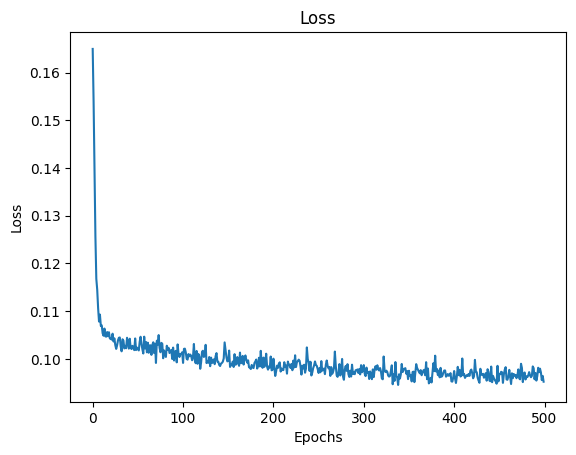

In [16]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

if not os.path.exists('.trained'):
    os.makedirs('.trained')

import datetime
now = datetime.datetime.now()
torch.save(model.state_dict(), f'.trained/{now.strftime("%Y-%m-%d_%H-%M-%S")}.pt')
torch.save(model.state_dict(), f'.trained/most_recent.pt')

In [20]:
import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.dataset as dataset

test_map = 'assets/zuttosummer_map.osu'
test_replay = 'assets/1hope_replay.osr'
test_song = 'assets/1hope_song.mp3'

test_map = bm.load(test_map)
test_replay = rp.load(test_replay)

data = dataset.input_data(test_map)
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data).to(device)

In [21]:
with torch.no_grad():
    replay_data = model(data).to('cpu').numpy()
    
replay_data = np.concatenate(replay_data)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
np.save('.generated\\' + "zuttosummer" + '.npy', replay_data)

In [19]:
import osu.preview.preview as preview

preview.preview_replay(replay_data, test_map, test_song)